<a href="https://colab.research.google.com/github/ToanToan110/SalesPrediction/blob/main/SalesPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Nội dung:***

Bằng cách nắm bắt được tình hinh kinh doanh hiện tại dựa trên cấp độ con người (như Lifetime value, Churn rate, Segment,...) doanh nghiệp có thể mở rộng bức tranh kinh doanh thông qua việc nắm bắt doanh số, xem xét các chiến lược trên từng khách hàng có ảnh hưởng như thế nào tới doanh số.

Từ đó đưa ra các kế hoạch tài chính, đầu tư, tiếp thị và tính toán các giá trị gia tăng.

***Kỹ thuật sử dụng chính:***

Time series Forecasting

***Outcome***
Dự đoán doanh số trong 2 tháng tới

#  I. Import Needed library

In [ ]:
from datetime import datetime, timedelta,date
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
# import plotly.plotly as py
import plotly.offline as pyoff
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# !unzip "/content/drive/MyDrive/Colab Notebooks/Data Driven Growth Series/train.csv.zip"
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Driven Growth Series/SalesData.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


<Axes: xlabel='date'>

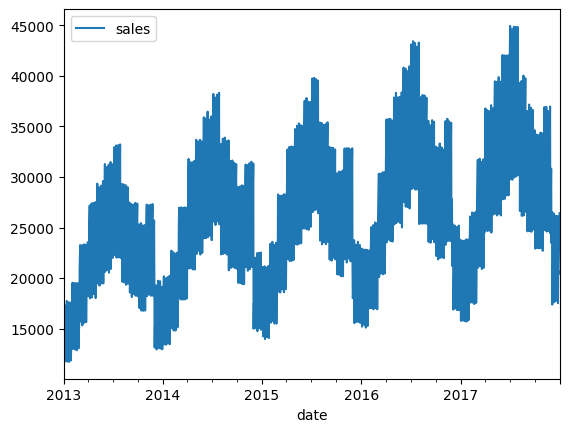

In [ ]:
# @title Overview trend
df['date'] = pd.to_datetime(df['date'])
# df = df[df['date']>='2015-01-01']
# time_plot = df.groupby('date')['sales'].sum().reset_index()

#represent month in date field as its first day
# df['month'] = df['date'].dt.year.astype('str') + '-' + df['date'].dt.month.astype('str') + '-01'
# df['month'] = pd.to_datetime(df['month'])
# df['month'] = df['date']
#groupby date and sum the sales
df_sales = df.groupby('date').sales.sum().reset_index()
df_sales.plot(kind = 'line', x='date', y = 'sales')
# df_sales.head(10)

**Nhận xét:** Doanh số theo thời gian là một đại lượng có tính chu kỳ.

# II. Lập mô hình dự báo:

Đối với chuỗi thời gian có tính cyclic (chu kỳ), tập dữ liệu cần thỏa mãn một số yêu cầu:

- Chuỗi thời gian hiện tại cần có chu kỳ theo năm, cứ sua 1 năm thì sự lên xuống lại lập lại. => tạo ra các tính năng để thể hiện sự biến đổi của chu kì trước
=> SỬ dụng lag feature để tạo ra doanh thu của 30 ngày trước

In [ ]:
#create a new dataframe to model the difference
df_diff = df_sales.copy()
#add previous sales to the next row
df_diff['prev_sales'] = df_diff['sales'].shift(1)
#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['sales'] - df_diff['prev_sales'])
df_diff.head(11)

,date,sales,prev_sales,diff
1,2013-01-02,13678,13696.0,-18.0
2,2013-01-03,14488,13678.0,810.0
3,2013-01-04,15677,14488.0,1189.0
4,2013-01-05,16237,15677.0,560.0
5,2013-01-06,17291,16237.0,1054.0
6,2013-01-07,11769,17291.0,-5522.0
7,2013-01-08,13560,11769.0,1791.0
8,2013-01-09,13878,13560.0,318.0
9,2013-01-10,14642,13878.0,764.0
10,2013-01-11,15633,14642.0,991.0


In [ ]:
# df_diff.plot(kind = 'line', x='month', y = 'diff')

In [ ]:
#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_sales'],axis=1)
# df_supervised = df_diff.copy()
#adding lags
for inc in range(1,31):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)
df_supervised.head(11)

,date,sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
0,2013-02-01,17473,2749.0,1333.0,-333.0,1876.0,-5731.0,1018.0,921.0,1168.0,...,991.0,764.0,318.0,1791.0,-5522.0,1054.0,560.0,1189.0,810.0,-18.0
1,2013-02-02,18323,850.0,2749.0,1333.0,-333.0,1876.0,-5731.0,1018.0,921.0,...,1046.0,991.0,764.0,318.0,1791.0,-5522.0,1054.0,560.0,1189.0,810.0
2,2013-02-03,19544,1221.0,850.0,2749.0,1333.0,-333.0,1876.0,-5731.0,1018.0,...,1062.0,1046.0,991.0,764.0,318.0,1791.0,-5522.0,1054.0,560.0,1189.0
3,2013-02-04,12998,-6546.0,1221.0,850.0,2749.0,1333.0,-333.0,1876.0,-5731.0,...,-5995.0,1062.0,1046.0,991.0,764.0,318.0,1791.0,-5522.0,1054.0,560.0
4,2013-02-05,14956,1958.0,-6546.0,1221.0,850.0,2749.0,1333.0,-333.0,1876.0,...,1879.0,-5995.0,1062.0,1046.0,991.0,764.0,318.0,1791.0,-5522.0,1054.0
5,2013-02-06,15124,168.0,1958.0,-6546.0,1221.0,850.0,2749.0,1333.0,-333.0,...,-34.0,1879.0,-5995.0,1062.0,1046.0,991.0,764.0,318.0,1791.0,-5522.0
6,2013-02-07,16112,988.0,168.0,1958.0,-6546.0,1221.0,850.0,2749.0,1333.0,...,996.0,-34.0,1879.0,-5995.0,1062.0,1046.0,991.0,764.0,318.0,1791.0
7,2013-02-08,17450,1338.0,988.0,168.0,1958.0,-6546.0,1221.0,850.0,2749.0,...,908.0,996.0,-34.0,1879.0,-5995.0,1062.0,1046.0,991.0,764.0,318.0
8,2013-02-09,18425,975.0,1338.0,988.0,168.0,1958.0,-6546.0,1221.0,850.0,...,799.0,908.0,996.0,-34.0,1879.0,-5995.0,1062.0,1046.0,991.0,764.0
9,2013-02-10,19501,1076.0,975.0,1338.0,988.0,168.0,1958.0,-6546.0,1221.0,...,1318.0,799.0,908.0,996.0,-34.0,1879.0,-5995.0,1062.0,1046.0,991.0


In [ ]:
# @title Kiểm tra tính giải thích của các đặc trưng
# Import statsmodels.formula.api
import statsmodels.formula.api as smf


glm_columns = []

for column in df_supervised.columns:
    if column not in ['date'	,'sales',	'diff']:
        glm_columns.append(column)
glm_columns = ' + '.join(glm_columns)


# Define the regression formula
model = smf.ols(formula='diff ~ {}'.format(glm_columns), data=df_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print("Độ giải thích của các đặc trưng đối với phương sai của mô hình là: {}".format(regression_adj_rsq))

Độ giải thích của các đặc trưng đối với phương sai của mô hình là: 0.9683328879578974


In [ ]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler
df_model = df_supervised.drop(['sales','date'],axis=1)
#split train and test set
train_set, test_set = df_model[0:-60].values, df_model[-60:].values
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)
# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [ ]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
model = Sequential()
model.add(LSTM(2, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=1, shuffle=False)

Epoch 1/10
1735/1735 [==============================] - 18s 6ms/step - loss: 0.0214
Epoch 2/10
1735/1735 [==============================] - 7s 4ms/step - loss: 0.0048
Epoch 3/10
1735/1735 [==============================] - 5s 3ms/step - loss: 0.0043
Epoch 4/10
1735/1735 [==============================] - 6s 4ms/step - loss: 0.0042
Epoch 5/10
1735/1735 [==============================] - 5s 3ms/step - loss: 0.0041
Epoch 6/10
1735/1735 [==============================] - 6s 3ms/step - loss: 0.0040
Epoch 7/10
1735/1735 [==============================] - 6s 3ms/step - loss: 0.0039
Epoch 8/10
1735/1735 [==============================] - 5s 3ms/step - loss: 0.0039
Epoch 9/10
1735/1735 [==============================] - 7s 4ms/step - loss: 0.0039
Epoch 10/10
1735/1735 [==============================] - 5s 3ms/step - loss: 0.0038


In [ ]:
y_pred = model.predict(X_test,batch_size=1)
#for multistep prediction, you need to replace X_test values with the predictions coming from t-1
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    # print np.concatenate([y_pred[index],X_test[index]],axis=1)
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

60/60 [==============================] - 0s 2ms/step


In [ ]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df_sales[-61:].date)
act_sales = list(df_sales[-61:].sales)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)
#for multistep prediction, replace act_sales with the predicted sales

In [ ]:
#merge with actual sales dataframe
df_sales_pred = pd.merge(df_sales,df_result,on='date',how='left')
df_sales_pred = df_sales_pred[df_sales_pred['date'] >= '2017-06-01']
#plot actual and predicted
plot_data = [
    go.Scatter(
        x=df_sales_pred['date'],
        y=df_sales_pred['sales'],
        name='actual'
    ),
        go.Scatter(
        x=df_sales_pred['date'],
        y=df_sales_pred['pred_value'],
        name='predicted'
    )

]
plot_layout = go.Layout(
        title='Sales Prediction'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

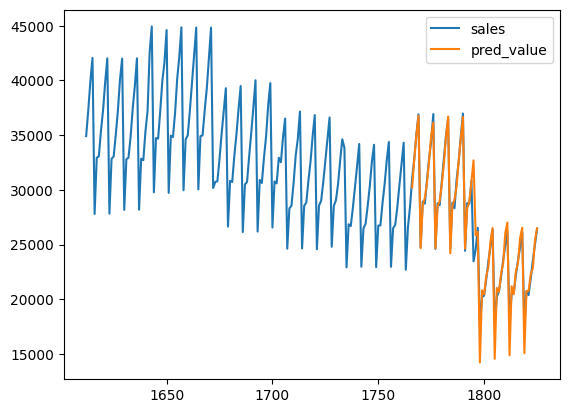

In [ ]:
df_sales_pred['sales'].plot()
df_sales_pred['pred_value'].plot()
plt.legend()
plt.show()

## Apraoch 2: Hybrid Model (next step)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess
from xgboost import XGBRegressor

# You'll add fit and predict methods to this minimal class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

def fit(self, X_1, X_2, y):
    # YOUR CODE HERE: fit self.model_1
    model = LinearRegression(fit_intercept = True)
    self.model_1.fit(X_1, y)

    y_fit = pd.DataFrame(
        # YOUR CODE HERE: make predictions with self.model_1
        self.model_1.predict(X_1),
        index=X_1.index, columns=y.columns,
    )

    # YOUR CODE HERE: compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    # YOUR CODE HERE: fit self.model_2 on residuals
    self.model_2.fit(X_2, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid

def predict(self, X_1, X_2):
    y_pred = pd.DataFrame(
        # YOUR CODE HERE: predict with self.model_1
        self.model_1.predict(X_1),
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    # YOUR CODE HERE: add self.model_2 predictions to y_pred
    y_pred += self.model_2.predict(X_2)

    return y_pred.unstack()  # long to wide

# Add method to class
BoostedHybrid.fit = fit
BoostedHybrid.predict = predict

In [ ]:
y = df.groupby(['date', 'store'])['sales'].sum().reset_index()
y = y.pivot(index='date', columns='store', values='sales')
# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()
X_1.head()

In [ ]:
# X_2: Features for XGBoost
X_2 = df.groupby(['date', 'store'])['sales'].sum().reset_index()
X_2["day"] = X_2['date'].dt.day
X_2.set_index('date', inplace = True)
X_2.head()

In [ ]:
# model = BoostedHybrid(LinearRegression(),XGBRegressor())
# y_train, y_valid = y[:"2016-01-01"], y["2016-01-02":]
# X1_train, X1_valid = X_1[: "2016-01-01"], X_1["2016-01-02" :]
# X2_train, X2_valid = X_2.loc[:"2016-01-01"], X_2.loc["2016-01-02":]

# # Some of the algorithms above do best with certain kinds of
# # preprocessing on the features (like standardization), but this is
# # just a demo.
# model.fit(X1_train, X2_train, y_train)
# y_fit = model.predict(X1_train, X2_train).clip(0.0)
# y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

# families = y.columns[0:1]
# axs = y.loc(axis=1)[families].plot(
#     subplots=True, sharex=True, alpha=0.5,
# )
# _ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C2', ax=axs)
# _ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
# for ax, family in zip(axs, families):
#     ax.legend([])
#     ax.set_ylabel(family)

*Note: data.plot 2 lần -> plt.legend() -> plt.show()

Tài liệu tham khảo về LSTM: https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/